In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
results = {'000': 2783, '001': 1240, '100': 603, '111': 815, '110': 294, '010': 1712, '101': 485, '011': 260}

results_maxtomin = {'000': 2783, '010': 1712, '001': 1240, '111': 815, '100': 603, '101': 485, '110': 294, '011': 260}

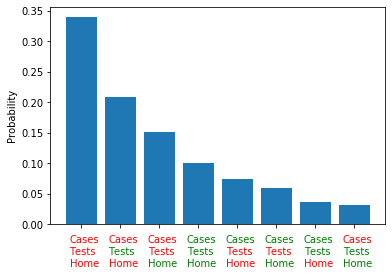

In [19]:
def determine_color(Cstate, Bstate, Astate):
    if Cstate == '0':
        Ccolor='red'
    elif Cstate=='1':
        Ccolor='green'
    if Bstate == '0':
        Bcolor='red'
    elif Bstate=='1':
        Bcolor='green'
    if Astate == '0':
        Acolor='red'
    elif Astate=='1':
        Acolor='green'
    return [Ccolor, Bcolor, Acolor]

def make_counts_hist(counts_results):
    probabilities = np.array([counts_results[k] for k in counts_results]) / sum(counts_results.values())
    print(probabilities)
    plt.bar(list(counts_results.keys()), counts_results.values())
    plt.ylabel('Counts')    
    plt.xticks(list(counts_results.keys()), [None])
    xpos_text = -0.3
    for key in counts_results:
        Cstate=key[0]
        Bstate=key[1]
        Astate=key[2]
        Ccolor, Bcolor, Acolor = determine_color(Cstate, Bstate, Astate)
        plt.text(xpos_text, -200,'Cases', color=Ccolor)
        plt.text(xpos_text, -400, 'Tests', color=Bcolor)
        plt.text(xpos_text, -600,'Home', color=Acolor)
        xpos_text += 1
    plt.show()
    return

def make_prob_hist(counts_results):
    probabilities = np.array([counts_results[k] for k in counts_results]) / sum(counts_results.values())
    #plt.bar(list(counts_results.keys()), probabilities)
    plt.bar(np.arange(8), probabilities)
    plt.ylabel('Probability')
    #plt.yticks(probabilities)
    
    
    plt.xticks(np.arange(8), [None])
    xpos_text = -0.3
    for key in counts_results:
        Cstate=key[0]
        Bstate=key[1]
        Astate=key[2]
        Ccolor, Bcolor, Acolor = determine_color(Cstate, Bstate, Astate)
        plt.text(xpos_text, -0.03,'Cases', color=Ccolor)
        plt.text(xpos_text, -0.05, 'Tests', color=Bcolor)
        plt.text(xpos_text, -0.07,'Home', color=Acolor)
        xpos_text += 1
    plt.show()
    return

make_prob_hist(results_maxtomin)        
